In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load datasets
employee = pd.read_csv('employee.csv')
resigned_table = pd.read_csv('resigned_table.csv')
resignation_reason = pd.read_csv('resignation_reason.csv')
exit_interview_survey = pd.read_csv('exit_interview_survey.csv')
employee_feedback_survey = pd.read_csv('employee_feedback_survey.csv')

# Merge relevant datasets
# Merging resigned table with resignation reason
resigned_data = pd.merge(resigned_table, resignation_reason, on='Resignation Reason ID', how='left')

# Merging resigned data with exit interview survey
resigned_data = pd.merge(resigned_data, exit_interview_survey, on='Employee ID', how='left')

# Filtering out only active employees
active_employees = employee[employee['Current Employment Status'] == 'Active']

# Creating a unified dataset for analysis
attrition_data = pd.merge(employee, resigned_data, on='Employee ID', how='left')

# Fill missing values for active employees
attrition_data.fillna({'Resigned Type': 'Not Resigned', 'Resignation Reason': 'None'}, inplace=True)

# Encode categorical variables
categorical_columns = ['Gender', 'Education Level', 'Department', 'Employment Type', 'Resigned Type']
encoder = LabelEncoder()

for col in categorical_columns:
    attrition_data[col] = encoder.fit_transform(attrition_data[col])

# Feature selection
features = ['Gender', 'Education Level', 'Department', 'Employment Type', 'Base Salary ($)', 
            'Times Promoted', 'Years at Company', 'Work Environment Feedback', 
            'Management/Team Experience Score']
target = 'Current Employment Status'

# Preparing data for the model
X = attrition_data[features]
y = attrition_data[target].apply(lambda x: 1 if x != 'Active' else 0)  # 1 for Resigned, 0 for Active

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data preparation complete. Ready for training.")

Data preparation complete. Ready for training.


In [3]:
from sklearn.preprocessing import LabelEncoder

# Identify columns with non-numeric data in X_train and X_test
categorical_columns = X_train.select_dtypes(include=['object']).columns

# Apply Label Encoding for simplicity (One-Hot Encoding is another option)
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])  # Ensure consistency with training data
    label_encoders[col] = le

print("Categorical columns encoded successfully!")


Categorical columns encoded successfully!


In [4]:
print(X_train.dtypes)


Gender                                int32
Education Level                       int32
Department                            int32
Employment Type                       int32
Base Salary ($)                     float64
Times Promoted                        int64
Years at Company                      int64
Work Environment Feedback             int32
Management/Team Experience Score    float64
dtype: object


In [5]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

print("Target variable encoded successfully!")


Target variable encoded successfully!


In [7]:
import pandas as pd

# Check for missing values in X_train
print("Missing values in X_train:")
print(X_train.isnull().sum())

# Convert y_train to a pandas Series to check for nulls
y_train_series = pd.Series(y_train)
print("\nMissing values in y_train:")
print(y_train_series.isnull().sum())

# Handle missing values in X_train (example: fill with median or drop)
X_train['Management/Team Experience Score'].fillna(X_train['Management/Team Experience Score'].median(), inplace=True)
print("\nMissing values in X_train after handling:")
print(X_train.isnull().sum())


Missing values in X_train:
Gender                                 0
Education Level                        0
Department                             0
Employment Type                        0
Base Salary ($)                        0
Times Promoted                         0
Years at Company                       0
Work Environment Feedback              0
Management/Team Experience Score    1248
dtype: int64

Missing values in y_train:
0

Missing values in X_train after handling:
Gender                              0
Education Level                     0
Department                          0
Employment Type                     0
Base Salary ($)                     0
Times Promoted                      0
Years at Company                    0
Work Environment Feedback           0
Management/Team Experience Score    0
dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_3356\184532985.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['Management/Team Experience Score'].fillna(X_train['Management/Team Experience Score'].median(), inplace=True)


In [8]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# If y_train has the wrong shape, reshape it
y_train = y_train.ravel()  # Flatten to (n_samples,)


X_train shape: (1440, 9)
y_train shape: (1440,)


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [10]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0],
}

# Initialize the model
gbm = GradientBoostingClassifier(random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=gbm,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings sampled
    scoring='accuracy',  # Metric to optimize
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all processors
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters and accuracy
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5, 'learning_rate': 0.2}
Best Accuracy: 1.0


In [16]:
import numpy as np

# Check for missing values in the NumPy array
missing_values = np.isnan(X_test).sum()
print(f"Total missing values in X_test: {missing_values}")


Total missing values in X_test: 313


In [18]:
# Assuming these were the original column names
original_columns = [
    "Gender", "Education Level", "Department", "Employment Type",
    "Base Salary ($)", "Times Promoted", "Years at Company",
    "Work Environment Feedback", "Management/Team Experience Score"
]

# Recreate DataFrame
X_test = pd.DataFrame(X_test, columns=original_columns)


In [19]:
# Save column names
original_columns = X_test.columns


In [20]:
# Convert NumPy array back to DataFrame
X_test = pd.DataFrame(X_test, columns=original_columns)


In [21]:
print("Missing values in X_test:")
print(X_test.isnull().sum())


Missing values in X_test:
Gender                                0
Education Level                       0
Department                            0
Employment Type                       0
Base Salary ($)                       0
Times Promoted                        0
Years at Company                      0
Work Environment Feedback             0
Management/Team Experience Score    313
dtype: int64


In [22]:
# Handle missing values by imputing with median
X_test['Management/Team Experience Score'] = X_test['Management/Team Experience Score'].fillna(
    X_test['Management/Team Experience Score'].median()
)

# Verify if missing values have been resolved
print("Missing values in X_test after imputation:")
print(X_test.isnull().sum())


Missing values in X_test after imputation:
Gender                              0
Education Level                     0
Department                          0
Employment Type                     0
Base Salary ($)                     0
Times Promoted                      0
Years at Company                    0
Work Environment Feedback           0
Management/Team Experience Score    0
dtype: int64


In [23]:
# Perform predictions with the cleaned data
y_pred = best_model.predict(X_test)

# Evaluate model performance
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[313   0]
 [  0  47]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       313
           1       1.00      1.00      1.00        47

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360



C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [24]:
# Example: Adjusting class weights for imbalanced classification
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(class_weight="balanced")
model.fit(X_train, y_train)


TypeError: GradientBoostingClassifier.__init__() got an unexpected keyword argument 'class_weight'

In [25]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_model, X_train, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())


Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation score: 1.0


In [26]:
feature_importances = best_model.feature_importances_
pd.Series(feature_importances, index=X_train.columns).plot(kind='bar')


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [27]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [28]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train the model
model = GradientBoostingClassifier()
model.fit(X_train_resampled, y_train_resampled)


GradientBoostingClassifier()

<Axes: >

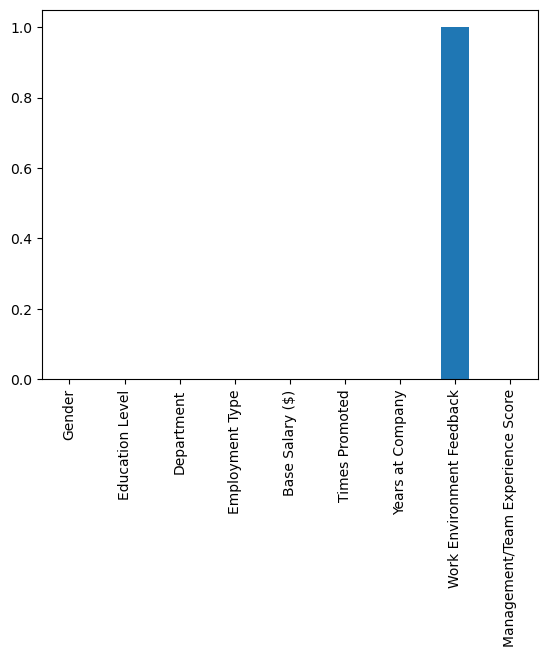

In [29]:
# Convert X_train (which is a numpy array) back to DataFrame with column names
X_train_df = pd.DataFrame(X_train, columns=original_columns)

# Now plot feature importances
feature_importances = best_model.feature_importances_
pd.Series(feature_importances, index=X_train_df.columns).plot(kind='bar')
